In [20]:
import numpy as np
import tensorflow as tf
import tensorflow.keras.layers as tfl
import math
import h5py
import matplotlib.pyplot as plt
from matplotlib.pyplot import imread
import scipy
from PIL import Image
import pandas as pd
import tensorflow.keras.layers as tfl
from tensorflow.python.framework import ops
from termcolor import colored

from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dropout 
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import concatenate
from tensorflow.keras.layers import ZeroPadding2D
from tensorflow.keras.layers import Dense

## Load the Data and Split the Data into Train/Test Sets
We will be using the Happy House dataset. Our task will be to build a ConvNet that determines whether the people in the images are smiling or not

In [21]:

def load_happy_dataset():
    train_dataset = h5py.File('datasets/train_happy.h5', "r")
    train_set_x_orig = np.array(train_dataset["train_set_x"][:]) # your train set features
    train_set_y_orig = np.array(train_dataset["train_set_y"][:]) # your train set labels

    test_dataset = h5py.File('datasets/test_happy.h5', "r")
    test_set_x_orig = np.array(test_dataset["test_set_x"][:]) # your test set features
    test_set_y_orig = np.array(test_dataset["test_set_y"][:]) # your test set labels

    classes = np.array(test_dataset["list_classes"][:]) # the list of classes
    
    train_set_y_orig = train_set_y_orig.reshape((1, train_set_y_orig.shape[0]))
    test_set_y_orig = test_set_y_orig.reshape((1, test_set_y_orig.shape[0]))
    
    return train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig, classes
    

X_train_orig, Y_train_orig, X_test_orig, Y_test_orig, classes = load_happy_dataset()

# Normalize image vectors
X_train = X_train_orig/255.
X_test = X_test_orig/255.

# Reshape
Y_train = Y_train_orig.T
Y_test = Y_test_orig.T

print ("number of training examples = " + str(X_train.shape[0]))
print ("number of test examples = " + str(X_test.shape[0]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(Y_train.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(Y_test.shape))

number of training examples = 600
number of test examples = 150
X_train shape: (600, 64, 64, 3)
Y_train shape: (600, 1)
X_test shape: (150, 64, 64, 3)
Y_test shape: (150, 1)


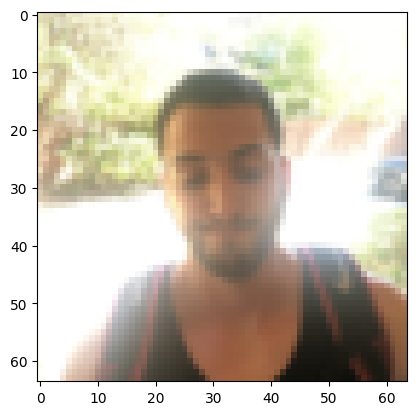

In [22]:
#Lets view an image
index = 124
plt.imshow(X_train_orig[index]) #display sample training image
plt.show()

## Create the Sequential Model

In [23]:
def happyModel():
    """
    Implements the forward propagation for the binary classification model:
    ZEROPAD2D -> CONV2D -> BATCHNORM -> RELU -> MAXPOOL -> FLATTEN -> DENSE

    

    Returns:
    model -- TF Keras model (object containing the information for the entire training process)
    """
    model = tf.keras.Sequential([

        # ZeroPadding2D with padding 3, input shape of 64 x 64 x 3
        tfl.ZeroPadding2D(padding=3, input_shape=(64, 64, 3)),
        
        # Conv2D with 32 7x7 filters and stride of 1
        tfl.Conv2D(filters=32, kernel_size=7, strides=1),
        
        # BatchNormalization for axis 3
        tfl.BatchNormalization(axis=3),
        
        # ReLU
        tfl.ReLU(),
        
        # Max Pooling 2D with default parameters (pool_size=(2,2), strides=(2,2))
        tfl.MaxPooling2D(),
        
        # Flatten layer
        tfl.Flatten(),
        
        # Dense layer with 1 unit for output & 'sigmoid' activation
        tfl.Dense(units=1, activation='sigmoid')

        ])

    return model

In [24]:
def summary(model):
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    result = []
    for layer in model.layers:
        descriptors = [layer.__class__.__name__, layer.output.shape, layer.count_params()]
        if (type(layer) == Conv2D):
            descriptors.append(layer.padding)
            descriptors.append(layer.activation.__name__)
            descriptors.append(layer.kernel_initializer.__class__.__name__)
        if (type(layer) == MaxPooling2D):
            descriptors.append(layer.pool_size)
            descriptors.append(layer.strides)
            descriptors.append(layer.padding)
        if (type(layer) == Dropout):
            descriptors.append(layer.rate)
        if (type(layer) == ZeroPadding2D):
            descriptors.append(layer.padding)
        if (type(layer) == Dense):
            descriptors.append(layer.activation.__name__)
        result.append(descriptors)
    return result
    
happy_model = happyModel()
# Print a summary for each layer

for layer in summary(happy_model):
    print(layer)

['ZeroPadding2D', (None, 70, 70, 3), 0, ((3, 3), (3, 3))]
['Conv2D', (None, 64, 64, 32), 4736, 'valid', 'linear', 'GlorotUniform']
['BatchNormalization', (None, 64, 64, 32), 128]
['ReLU', (None, 64, 64, 32), 0]
['MaxPooling2D', (None, 32, 32, 32), 0, (2, 2), (2, 2), 'valid']
['Flatten', (None, 32768), 0]
['Dense', (None, 1), 32769, 'sigmoid']


In [28]:
#Compile the model for training with optimizer and loss of choice
happy_model.compile(optimizer='adam',
                   loss='binary_crossentropy',
                   metrics=['accuracy'])

It's time to check your model's parameters with the .summary() method. This will display the types of layers you have, the shape of the outputs, and how many parameters are in each layer.

In [29]:
happy_model.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ zero_padding2d_7                │ (None, 70, 70, 3)      │             0 │
│ (ZeroPadding2D)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 64, 64, 32)     │         4,736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 64, 64, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_7 (ReLU)                  │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_7 (Flatten)             │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │        32,769 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 37,633 (147.00 KB)

 Trainable params: 37,569 (146.75 KB)

 Non-trainable params: 64 (256.00 B)

Conv2d_7 parameter numbers = (filter/kernel size * number of channels of input * total number of filters) + bias for each filter = (7*7 * 3 * 32)  + 32 = 4736

## Train and Evaluate the Model

 You do have the option to specify epoch number or minibatch size if you like (for example, in the case of an un-batched dataset).

In [30]:
happy_model.fit(X_train, Y_train, epochs=10, batch_size=16)

Epoch 1/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - accuracy: 0.7683 - loss: 0.6181
Epoch 2/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 0.9333 - loss: 0.1745
Epoch 3/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.9117 - loss: 0.2697
Epoch 4/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.9150 - loss: 0.2250
Epoch 5/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 0.9500 - loss: 0.1403
Epoch 6/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 0.9600 - loss: 0.1112
Epoch 7/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 0.9717 - loss: 0.0729
Epoch 8/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.9717 - loss: 0.0694
Epoch 9/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.9750 - loss: 0.0746
Epoch 10/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 0.9567 - loss: 0.1229


In [32]:
#use .evaluate() to evaluate against your test set. This function will print the value of the loss function and the performance metrics specified during the compilation of the model. In this case, the binary_crossentropy and the accuracy respectively.

happy_model.evaluate(X_test, Y_test)

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.8600 - loss: 0.2506


[0.25055477023124695, 0.8600000143051147]

But what if you need to build a model with shared layers, branches, or multiple inputs and outputs? This is where Sequential, with its beautifully simple yet limited functionality, won't be able to help you.Functional API is needed.It is slightly more complex but highly flexible.

## The Functional API

The Functional API can handle models with non-linear topology, shared layers, as well as layers with multiple inputs or outputs. Imagine that, where the Sequential API requires the model to move in a linear fashion through its layers, the Functional API allows much more flexibility. Where Sequential is a straight line, a Functional model is a graph, where the nodes of the layers can connect in many more ways than one.

In the Functional API, you create a graph of layers. This is what allows such great flexibility.

We will use Keras' flexible Functional API to build a ConvNet that can differentiate between 6 sign language digits.

In [33]:
#Load the Dataset
def load_signs_dataset():
    train_dataset = h5py.File('datasets/train_signs.h5', "r")
    train_set_x_orig = np.array(train_dataset["train_set_x"][:]) # your train set features
    train_set_y_orig = np.array(train_dataset["train_set_y"][:]) # your train set labels

    test_dataset = h5py.File('datasets/test_signs.h5', "r")
    test_set_x_orig = np.array(test_dataset["test_set_x"][:]) # your test set features
    test_set_y_orig = np.array(test_dataset["test_set_y"][:]) # your test set labels

    classes = np.array(test_dataset["list_classes"][:]) # the list of classes
    
    train_set_y_orig = train_set_y_orig.reshape((1, train_set_y_orig.shape[0]))
    test_set_y_orig = test_set_y_orig.reshape((1, test_set_y_orig.shape[0]))
    
    return train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig, classes

X_train_orig, Y_train_orig, X_test_orig, Y_test_orig, classes = load_signs_dataset()

y = 4


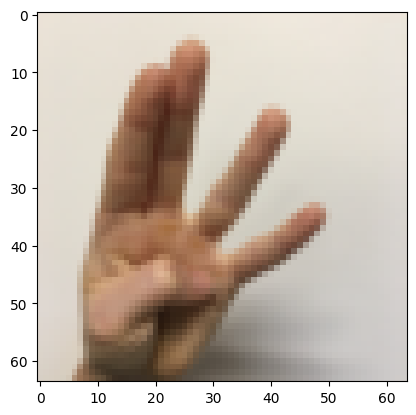

In [34]:
# Example of an image from the dataset
index = 9
plt.imshow(X_train_orig[index])
print ("y = " + str(np.squeeze(Y_train_orig[:, index])))

In [40]:
def convert_to_one_hot(Y, C):
    Y = np.eye(C)[Y.reshape(-1)].T
    return Y

#Preprocess the data
X_train = X_train_orig/255.
X_test = X_test_orig/255.        
Y_train = convert_to_one_hot(Y_train_orig, 6).T
Y_test = convert_to_one_hot(Y_test_orig, 6).T

#Examine Shape of data
print ("number of training examples = " + str(X_train.shape[0]))
print ("number of test examples = " + str(X_test.shape[0]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(Y_train.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(Y_test.shape))

number of training examples = 1080
number of test examples = 120
X_train shape: (1080, 64, 64, 3)
Y_train shape: (1080, 6)
X_test shape: (120, 64, 64, 3)
Y_test shape: (120, 6)


NOTES

tf.keras.layers.Flatten(): given a tensor "P", this function takes each training (or test) example in the batch and flattens it into a 1D vector.
tf.keras.layers.Dense(units= ... , activation='softmax')(F): given the flattened input F, it returns the output computed using a fully connected layer. 

The words "kernel" and "filter" are used to refer to the same thing. The word "filter" accounts for the amount of "kernels" that will be used in a single convolution layer. "Pool" is the name of the operation that takes the max or average value of the kernels.

In [41]:
def convolutional_model(input_shape):
    """
    Implements the forward propagation for the model:
    CONV2D -> RELU -> MAXPOOL -> CONV2D -> RELU -> MAXPOOL -> FLATTEN -> DENSE

    Arguments:
    input_img -- input dataset, of shape (input_shape)

    Returns:
    model -- TF Keras model (object containing the information for the entire training process)
    """

    input_img = tf.keras.Input(shape=input_shape)


    # CONV2D: 8 filters of 4x4, stride of 1, padding 'SAME'-in conv2D, padding is chosing such that the output shape remains the same
    Z1 = tf.keras.layers.Conv2D(
        filters=8,
        kernel_size=(4, 4),
        strides=1,
        padding='same',
        name='conv1'
    )(input_img)
    
    # RELU
    A1 = tf.keras.layers.ReLU()(Z1)
    
    # MAXPOOL: window 8x8, stride 8, padding 'SAME'
    P1 = tf.keras.layers.MaxPooling2D(
        pool_size=(8, 8),
        strides=8,
        padding='same',
        name='pool1'
    )(A1)
    
    # CONV2D: 16 filters of 2x2, stride 1, padding 'SAME'
    Z2 = tf.keras.layers.Conv2D(
        filters=16,
        kernel_size=(2, 2),
        strides=1,
        padding='same',
        name='conv2'
    )(P1)
    
    # RELU
    A2 = tf.keras.layers.ReLU()(Z2)
    
    # MAXPOOL: window 4x4, stride 4, padding 'SAME'
    P2 = tf.keras.layers.MaxPooling2D(
        pool_size=(4, 4),
        strides=4,
        padding='same',
        name='pool2'
    )(A2)
    
    # FLATTEN
    F = tf.keras.layers.Flatten()(P2)
    
    # Dense layer: 6 neurons, softmax activation
    # (for 6-class classification)
    outputs = tf.keras.layers.Dense(
        units=6,
        activation='softmax',
        name='dense_output'
    )(F)

    model = tf.keras.Model(inputs=input_img, outputs=outputs)
    return model

In [42]:
conv_model = convolutional_model((64, 64, 3))
conv_model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
conv_model.summary()


Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_8 (InputLayer)      │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1 (Conv2D)                  │ (None, 64, 64, 8)      │           392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_8 (ReLU)                  │ (None, 64, 64, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool1 (MaxPooling2D)            │ (None, 8, 8, 8)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2 (Conv2D)                  │ (None, 8, 8, 16)       │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_9 (ReLU)                  │ (None, 8, 8, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool2 (MaxPooling2D)            │ (None, 2, 2, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_8 (Flatten)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_output (Dense)            │ (None, 6)              │           390 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,310 (5.12 KB)

 Trainable params: 1,310 (5.12 KB)

 Non-trainable params: 0 (0.00 B)

Conv1 parameter numbers = (filter/kernel size * number of channels of input * total number of filters) + bias for each filter = (4*4 * 3 * 8)  + 8 = 392

Conv2 parameter numbers = (filter/kernel size * number of channels of input * total number of filters) + bias for each filter = (2*2 * 8 * 1)  + 16 = 528

## Train the Model

In [43]:
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, Y_train)).batch(64)
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, Y_test)).batch(64)
history = conv_model.fit(train_dataset, epochs=100, validation_data=test_dataset)

Epoch 1/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.1907 - loss: 1.8056 - val_accuracy: 0.2000 - val_loss: 1.7843
Epoch 2/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.2213 - loss: 1.7854 - val_accuracy: 0.3000 - val_loss: 1.7789
Epoch 3/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.2509 - loss: 1.7808 - val_accuracy: 0.2833 - val_loss: 1.7747
Epoch 4/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.2426 - loss: 1.7776 - val_accuracy: 0.3333 - val_loss: 1.7693
Epoch 5/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.2722 - loss: 1.7729 - val_accuracy: 0.3500 - val_loss: 1.7637
Epoch 6/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.3148 - loss: 1.7674 - val_accuracy: 0.3667 - val_loss: 1.7572
Epoch 7/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.3694 - loss: 1.7610 - val_accuracy: 0.4250 - val_loss: 1.7480
Epoch 8/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.3815 - loss: 1.7533 - val_accuracy: 0.

## History Object

The history object is an output of the .fit() operation, and provides a record of all the loss and metric values in memory. It's stored as a dictionary that you can retrieve at history.history:

In [44]:
history.history

{'accuracy': [0.19074073433876038,
  0.2212962955236435,
  0.2509259283542633,
  0.24259258806705475,
  0.27222222089767456,
  0.31481480598449707,
  0.36944442987442017,
  0.38148146867752075,
  0.39814814925193787,
  0.4009259343147278,
  0.4148148000240326,
  0.41018518805503845,
  0.42129629850387573,
  0.442592591047287,
  0.4583333432674408,
  0.4712963104248047,
  0.48148149251937866,
  0.49444442987442017,
  0.5074074268341064,
  0.510185182094574,
  0.5259259343147278,
  0.5351851582527161,
  0.5462962985038757,
  0.5601851940155029,
  0.5685185194015503,
  0.5833333134651184,
  0.595370352268219,
  0.6074073910713196,
  0.6185185313224792,
  0.6379629373550415,
  0.6472222208976746,
  0.6574074029922485,
  0.6740740537643433,
  0.6814814805984497,
  0.6851851940155029,
  0.6916666626930237,
  0.7009259462356567,
  0.7064814567565918,
  0.7194444537162781,
  0.7231481671333313,
  0.7250000238418579,
  0.7277777791023254,
  0.7351852059364319,
  0.7388888597488403,
  0.74444442

/var/folders/hf/81yfsz694rx2svmh31g42bb80000gn/T/ipykernel_57988/2902719050.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_loss.rename(columns={'loss':'train','val_loss':'validation'},inplace=True)
/var/folders/hf/81yfsz694rx2svmh31g42bb80000gn/T/ipykernel_57988/2902719050.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_acc.rename(columns={'accuracy':'train','val_accuracy':'validation'},inplace=True)


[Text(0.5, 0, 'Epoch'), Text(0, 0.5, 'Accuracy')]

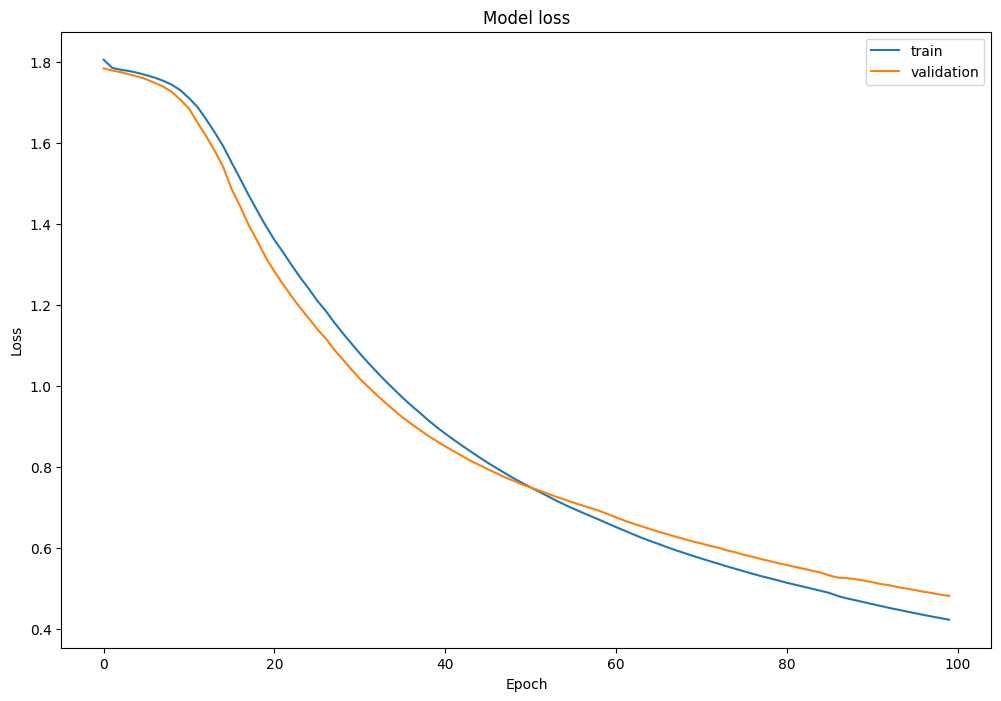

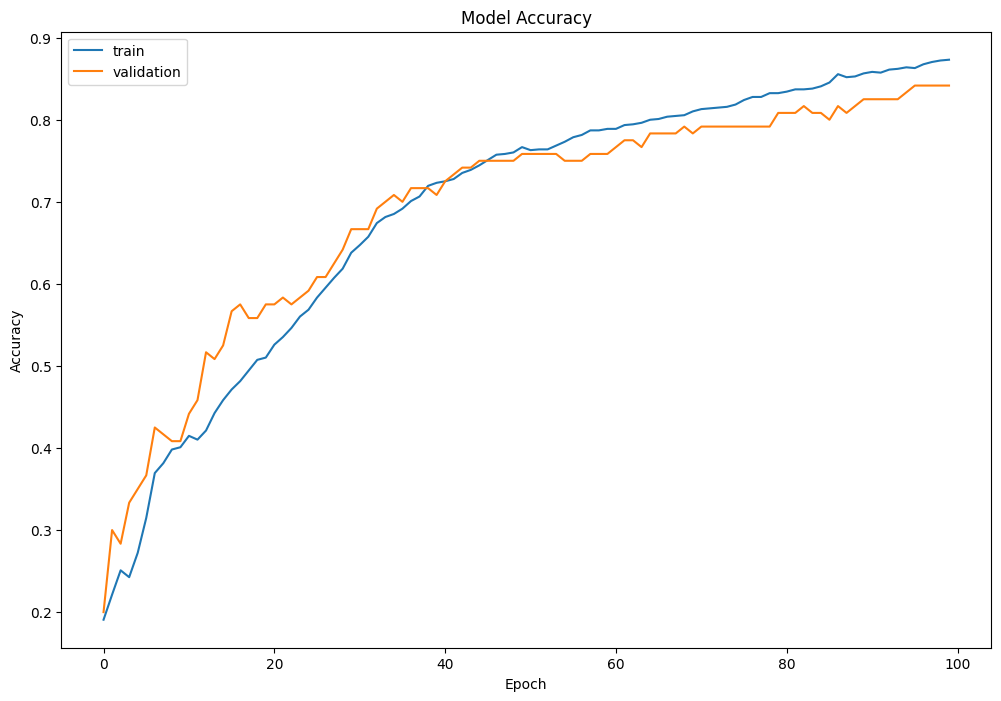

In [45]:
# The history.history["loss"] entry is a dictionary with as many values as epochs that the
# model was trained on.
df_loss_acc = pd.DataFrame(history.history)
df_loss= df_loss_acc[['loss','val_loss']]
df_loss.rename(columns={'loss':'train','val_loss':'validation'},inplace=True)
df_acc= df_loss_acc[['accuracy','val_accuracy']]
df_acc.rename(columns={'accuracy':'train','val_accuracy':'validation'},inplace=True)
df_loss.plot(title='Model loss',figsize=(12,8)).set(xlabel='Epoch',ylabel='Loss')
df_acc.plot(title='Model Accuracy',figsize=(12,8)).set(xlabel='Epoch',ylabel='Accuracy')